In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.CipherBreaker import CipherBreaker
from src.CipherUtils import (
    TextDecoder,
    TextEncoder,
    CipherGenerator,
    TextPreProcessor,
)
from src.ProbabilityMatrix import ProbabilityMatrix

# Functions needed for the HMM_code
from src.HMM_utils import map_alphabet_to_numbers, string_to_numbers
from src.HMM_utils import find_mapping, numbers_to_string, invert_mapping
from src.HMM_utils import convert_numbers_to_letters

from src.HMM_functions import Baum_Welch
from src.HMM_functions import compute_f_log, Viterbi_log, reconstruct

from difflib import SequenceMatcher

In [2]:
def similar(a, b):
    """
    Given two strings a, b it returns a percentage of matching characters among the two
    """

    return np.mean(
        np.array(list(a.replace(" ", ""))) == np.array(list(b.replace(" ", "")))
    )

In [3]:
# Initialize classes and obtain the matrix of probabilities by training on the provided text
cipher_generator = CipherGenerator()
preprocess = TextPreProcessor()
text_encoder = TextEncoder()
text_decoder = TextDecoder()


# List of text file paths to build our corpus (where we learn the transitions probs)
file_paths = [
    "texts/moby_dick.txt",
    "texts/shakespeare.txt",
    "texts/james-joyce-a-portrait-of-the-artist-as-a-young-man.txt",
    "texts/james-joyce-dubliners.txt",
    "texts/james-joyce-ulysses.txt",
]

texts = []
for file_path in file_paths:
    with open(file_path, "r") as file:
        texts.append(file.read())

corpus = "".join(texts)


# preprocess the text, removing extra-characters

corpus = preprocess.lower(corpus)
unknown_chars = preprocess.unknown_chars(corpus)
# print(unknown_chars)
corpus = preprocess.remove_unknown_chars(corpus, unknown_chars=unknown_chars)
corpus = preprocess.remove_additional_spaces(corpus)

preprocess.save_text(
    corpus
)  # save text after preprocessing inside text_preprocessed.txt


# compute the transition probs
probability_matrix = ProbabilityMatrix(corpus)
probability_matrix.compute_probability_table()  # table needed for MCMC method
probability_matrix.compute_normalized_matrix()  # normalized matrix needed for HMM

In [4]:
def prepare_subtexts(path_to_file, lengths):
    """
    This function returns the subtext to use to assess accuracy in decryption

    Input:
        - path_to_file (str) giving the path to the text file
        - lengths (list of int) giving the text lengths to consider
    """

    with open(path_to_file, "r") as input_file:
        full_text = input_file.read()

    full_text = preprocess.lower(full_text)
    unknown_chars = preprocess.unknown_chars(full_text)
    full_text = preprocess.remove_unknown_chars(full_text, unknown_chars=unknown_chars)
    full_text = preprocess.remove_additional_spaces(full_text)

    subtexts = [
        " ".join(full_text.split()[: lengths[i]]) for i in range(len(lengths))
    ]  # Contains the ones for the varying lengths

    return subtexts

In [5]:
def accuracy_varying_text_length(
    subtexts,
    cipher_generator,
    probability_matrix,
    extract_top=5,
    n_iterations=3,
    max_iterations=10000,
    nstart=3,
    maxIter_BM=100,
    tol_BM=10e-3,
):
    """
    This function assesses the accuracy of the MCMC decryption + that of the HMM decryption process
    Input:
        - subtexts (list of str): a vector of text of different length
        - cipher_generator (CipherGenerator instance)
        - probability_matrix
        - extract_top(int) : After cipher breaking how many of the top ones we want to retain
        - n_iterations (int) : number of times we want to repeat the encryption-decryption for each text
        - max_iterations (int) : number of iterations in the cipher breaking procedure
        - nstart (int) : number of starting points in the cipher breaking procedure
        - maxIter_BM (int) = number of maximum number of iterations that can be performed by the BM algorithm
        - tol_BM (float) = after no updates larger than this we stop BM algorithm

    For each subtext it encrypts it and decrypts it n_iteration times.
        Everytime it finishes decrypting it compares the best extract_top (in terms of log likelihood) with the original string,
        and computes the accuracy as the proportion of characters matching for the string which matches best.
        Then for each subtext these are averaged over all n_iterations runs and are stored.
    """
    mean_accuracy_MCMC = []
    mean_accuracy_HMM_emission = []
    mean_accuracy_HMM_viterbi = []

    for subtext in subtexts:
        total_iterations = 0
        total_iterations_HMM_emission = 0
        total_iterations_HMM_viterbi = 0

        # We run n_iterations ciphers and measure the averge accuracy on those.
        for _ in range(n_iterations):
            cipher = cipher_generator.generate_cipher()
            encoded_text = text_encoder.encode_text(subtext, cipher)

            ######################################################### MCMC #########################################################

            # Initialize a code breaker for that encoded message
            cipher_breaker_nstart = CipherBreaker(
                cipher_generator=cipher_generator,
                ciphered_text=encoded_text,
                probability_table=probability_matrix.probability_table,
            )

            # Break the code and store the extract_top in a dictionary (avoid printing)
            cipher_breaker_nstart.break_cipher_nstart(
                iterations=max_iterations, print_interval=max_iterations, nstart=nstart
            )
            best_dict = cipher_breaker_nstart.extract_best(
                n_extract=extract_top, return_likelihood=True
            )

            # Extract only the text and store it in a list
            best_dict_text = [t[0] for t in best_dict]
            # print(best_dict_text)

            # Now we check the percentage of correct ones in the string we matched the most with
            # total_iterations stores the accuracy achieved over all iterations
            total_iterations = total_iterations + max(
                [
                    similar(subtext, best_dict_text[l])
                    for l in range(len(best_dict_text))
                ]
            )

            ######################################################### HMM #########################################################
            B_start = np.zeros((27, 27)) + 1 / 26
            B_start[:, -1] = np.zeros(27)
            B_start[-1, :] = np.zeros(27)
            B_start[-1, -1] = 1
            observed_ = string_to_numbers(
                encoded_text, mapping=map_alphabet_to_numbers()
            )

            emission = Baum_Welch(
                A=probability_matrix.normalized_matrix,
                B_start=B_start,
                pi=probability_matrix.normalized_matrix[-1, :],
                observed=observed_,
                maxIter=maxIter_BM,
                tol=tol_BM,
            )

            # Emission reconstruction
            mapping = find_mapping(emission.argmax(axis=1))
            emission_reconstruction = numbers_to_string(
                encoded_text, invert_mapping(mapping)
            )

            total_iterations_HMM_emission = total_iterations_HMM_emission + similar(
                subtext, emission_reconstruction
            )

            # Now we use Viterbi to obtain the most likely one
            f0, f = compute_f_log(
                A=probability_matrix.normalized_matrix, B=emission, observed=observed_
            )
            pmax, phi = Viterbi_log(f0, f)
            reconstruction = reconstruct(pmax, phi)
            reconstruction = reconstruction.astype(int)
            viterbi_reconstruction = convert_numbers_to_letters(reconstruction)
            total_iterations_HMM_viterbi = total_iterations_HMM_viterbi + similar(
                subtext, viterbi_reconstruction
            )

        mean_accuracy_MCMC.append(total_iterations / n_iterations)
        mean_accuracy_HMM_emission.append(total_iterations_HMM_emission / n_iterations)
        mean_accuracy_HMM_viterbi.append(total_iterations_HMM_viterbi / n_iterations)

    return mean_accuracy_MCMC, mean_accuracy_HMM_emission, mean_accuracy_HMM_viterbi

In [6]:
lengths = [2 ** (i) for i in range(3, 6)]
# An example which runs very fast
subtexts = prepare_subtexts("texts/moby_dick.txt", lengths=lengths)
accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

Iter 0 of start 1: ijvnosx zllqpwrt ivzz qs ptjqvsz tlqs esvxt vrl
Iter 0 of start 2: dgnpzah vkkoqufr dnvv oa qrgonav rkoa sanhr nfk
Iter 0 of start 3: uotfkqe jsswhmag utjj wq hgowtqj gswq yqteg tas
Not updating anymore after iteration 26
Iter 0 of start 1: xlifvpc gddhonzm xigg hp omlhipg mdhp wpicm izd
Iter 0 of start 2: fqzrdue ivvbmcho fzii bu moqbzui ovbu auzeo zhv


/Users/michelealessi/Desktop/HMM-for-text-decryption/src/HMM_functions.py:160: RuntimeWarning: divide by zero encountered in log
  tmp[k] = np.log(pi[k]) + np.log(B[k, observed[0]])
/Users/michelealessi/Desktop/HMM-for-text-decryption/src/HMM_functions.py:169: RuntimeWarning: divide by zero encountered in log
  tmp[j, k] = np.log(A[j, k]) + np.log(B[k, observed[i]])


Iter 0 of start 3: rocnytm zvvbqhaf rczz bt qfobctz fvbt stcmf cav
Not updating anymore after iteration 26
Iter 0 of start 1: cbdysfo kmmxlirw cdkk xf lwbxdfk wmxf gfdow drm
Iter 0 of start 2: lgpstuj rnnbcoxe lprr bu cegbpur enbu aupje pxn
Iter 0 of start 3: xtsbmqu pwwvcifr xspp vq crtvsqp rwvq gqsur sfw
Not updating anymore after iteration 26
Iter 0 of start 1: fiapmdh lkkuzcjg fall ud zgiuadl gkud wdahg ajk cdqdh uzct iko lkcj phdfzgdlw iaqzcj lzmmld kh
Iter 0 of start 2: wqozhxs pffujmcv wopp ux jvquoxp vfux axosv ocf mxlxs ujmg qfd pfmc zsxwjvxpa qoljmc pjhhpx fs
Iter 0 of start 3: ylezhkj dxxvtspn yedd vk tnlvekd nxvk mkejn epx skrkj vtsa lxi dxsp zjkytnkdm lertsp dthhdk xj
Not updating anymore after iteration 48
Iter 0 of start 1: yojhgkn vffeprbi yjvv ek pioejkv ifek ukjni jbf rkakn eprz ofw vfrb hnkypikvu ojaprb vpggvk fn
Iter 0 of start 2: cvokswi huueazjf cohh ew afveowh fuew lwoif oju zwbwi eazy vur huzj kiwcafwhl vobazj hasshw ui
Iter 0 of start 3: vwdposi yhhragxc vdyy r

([0.21666666666666667, 0.4261603375527426, 0.9976689976689976],
 [0.0, 0.6075949367088608, 0.7482517482517482],
 [0.275, 0.6582278481012658, 0.8041958041958042])

In [7]:
lengths = [10, 25, 50, 100, 250, 500, 1000]

In [8]:
# Use it on the Moby Dick text
subtexts = prepare_subtexts("texts/moby_dick.txt", lengths)
(
    Moby_Dick_accuracy_MCMC,
    Moby_Dick_accuracy_HMM_emission,
    Moby_Dick_accuracy_HMM_viterbi,
) = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)


# Use it on the article text
subtexts = prepare_subtexts("texts/article_tipping.txt", lengths)
(
    article_tipping_accuracy_MCMC,
    article_tipping_accuracy_HMM_emission,
    article_tipping_accuracy_HMM_viterbi,
) = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

# Use it on the war message text
subtexts = prepare_subtexts("texts/eisenhower_speech.txt", lengths)
(
    speech_accuracy_MCMC,
    speech_accuracy_HMM_emission,
    speech_accuracy_HMM_viterbi,
) = accuracy_varying_text_length(subtexts, cipher_generator, probability_matrix)

Iter 0 of start 1: dteohwy kffrnzga dekk rw natrewk afrw uweya egf zwbwy rnzx
Iter 0 of start 2: mqneoga dwwrzlbv mndd rg zvqrngd vwrg fgnav nbw lgiga rzly
Iter 0 of start 3: rjqhkfe saagdnbo rqss gf dojgqfs oagf pfqeo qba nfwfe gdny
Not updating anymore after iteration 42
Iter 0 of start 1: qifnvar cwwsxtld qfcc sa xdisfac dwsa oafrd flw tapar sxte
Iter 0 of start 2: vyusmnp zoobdfag vuzz bn dgybunz gobn wnupg uao fntnp bdfk
Iter 0 of start 3: ivdqhjf trrwamny idtt wj ayvwdjt yrwj zjdfy dnr mjxjf wamc
Not updating anymore after iteration 42
Iter 0 of start 1: cywoutn bhhfrxpa cwbb ft rayfwtb ahft ktwna wph xtltn frxm
Iter 0 of start 2: qtgysxu avvfzoli qgaa fx zitfgxa ivfx kxgui glv oxbxu fzoj
Iter 0 of start 3: qmndkbp wzzacxsf qnww ab cfmanbw fzab gbnpf nsz xbybp acxr
Not updating anymore after iteration 42
Iter 0 of start 1: ybusowd paavfqgj yupp vw fjbvuwp javw xwudj uga qwiwd vfqn bac paqg sdwyfjwpx buifqg pfoopw ad qa vaqwx fq vx sedjw uqn qaobfqg sudofyepud oa
Iter 0 of start 2

In [9]:
print("Results using MCMC algorithm:\n")
print("Moby Dick accuracy", Moby_Dick_accuracy_MCMC)
print("Article accuracy", article_tipping_accuracy_MCMC)
print("Eisenhower speech accuracy", speech_accuracy_MCMC)

print("Results using Emissions assigned by BM algorithm:\n")
print("Moby Dick accuracy", Moby_Dick_accuracy_HMM_emission)
print("Article accuracy", article_tipping_accuracy_HMM_emission)
print("Eisenhower speech accuracy", speech_accuracy_HMM_emission)

print("Results using reconstruction given by Viterbi algorithm:\n")
print("Moby Dick accuracy", Moby_Dick_accuracy_HMM_viterbi)
print("Article accuracy", article_tipping_accuracy_HMM_viterbi)
print("Eisenhower speech accuracy", speech_accuracy_HMM_viterbi)

Results using MCMC algorithm:

Moby Dick accuracy [0.27891156462585037, 0.6723646723646723, 1.0, 1.0, 1.0, 1.0, 1.0]
Article accuracy [0.14814814814814814, 0.6695652173913044, 0.8405797101449276, 0.9977220956719818, 1.0, 1.0, 1.0]
Eisenhower speech accuracy [0.4326241134751773, 0.782608695652174, 1.0, 1.0, 1.0, 1.0, 0.9998574280011406]
Results using Emissions assigned by BM algorithm:

Moby Dick accuracy [0.16326530612244897, 0.5470085470085471, 0.9702970297029703, 0.9237037037037036, 1.0, 0.9995505617977528, 0.8645251396648045]
Article accuracy [0.0, 0.0, 0.7874396135265701, 0.8147304479878512, 0.823937554206418, 0.8414367060884801, 0.8444037656903766]
Eisenhower speech accuracy [0.1631205673758865, 0.5130434782608696, 0.7361702127659574, 0.8815789473684209, 0.788010425716768, 0.871927554980595, 0.8721129170230967]
Results using reconstruction given by Viterbi algorithm:

Moby Dick accuracy [0.3673469387755102, 0.7435897435897436, 0.8564356435643564, 0.9155555555555556, 0.985585585585

In [10]:
# Write results to file
with open("outputs/MCMC_accuracies/Moby_Dick_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in Moby_Dick_accuracy_MCMC:
        file.write(str(num) + "\n")

with open("outputs/MCMC_accuracies/Article_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in article_tipping_accuracy_MCMC:
        file.write(str(num) + "\n")

with open("outputs/MCMC_accuracies/speech_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in speech_accuracy_MCMC:
        file.write(str(num) + "\n")

In [12]:
# Write results to file
with open("outputs/HMM_viterbi_accuracies/Moby_Dick_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in Moby_Dick_accuracy_HMM_emission:
        file.write(str(num) + "\n")

with open("outputs/HMM_viterbi_accuracies/Article_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in article_tipping_accuracy_HMM_emission:
        file.write(str(num) + "\n")

with open("outputs/HMM_viterbi_accuracies/speech_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in speech_accuracy_HMM_emission:
        file.write(str(num) + "\n")

In [14]:
# Write results to file
with open("outputs/HMM_emission_accuracies/Moby_Dick_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in Moby_Dick_accuracy_HMM_viterbi:
        file.write(str(num) + "\n")

with open("outputs/HMM_emission_accuracies/Article_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in article_tipping_accuracy_HMM_viterbi:
        file.write(str(num) + "\n")

with open("outputs/HMM_emission_accuracies/speech_accuracy.txt", "w") as file:
    # Convert each float to an integer and write it to the file
    for num in speech_accuracy_HMM_viterbi:
        file.write(str(num) + "\n")

## plot


['10', '25', '50', '100', '250', '500', '1000']


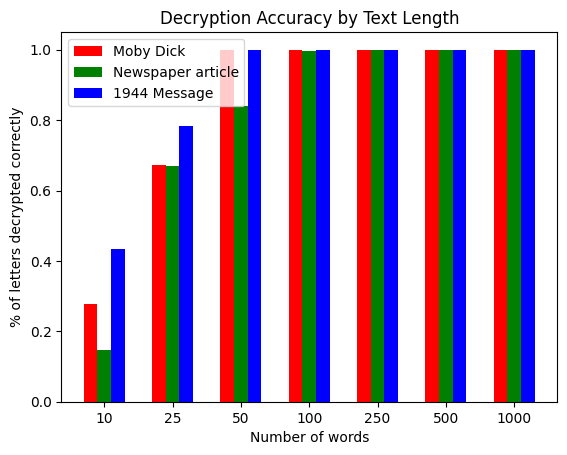

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of labels for the x-axis
labels = [str(length) for length in lengths]
print(labels)

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(labels))

# Plot the results using a bar plot
plt.bar(
    x_pos - bar_width, Moby_Dick_accuracy_MCMC, bar_width, color="r", label="Moby Dick"
)
plt.bar(
    x_pos,
    article_tipping_accuracy_MCMC,
    bar_width,
    color="g",
    label="Newspaper article",
)
plt.bar(
    x_pos + bar_width, speech_accuracy_MCMC, bar_width, color="b", label="1944 Message"
)

# Add labels, title, and legend
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.title("Decryption Accuracy by Text Length")
plt.xticks(x_pos, labels)
plt.legend()

# Display the plot
plt.show()

['10', '25', '50', '100', '250', '500', '1000']


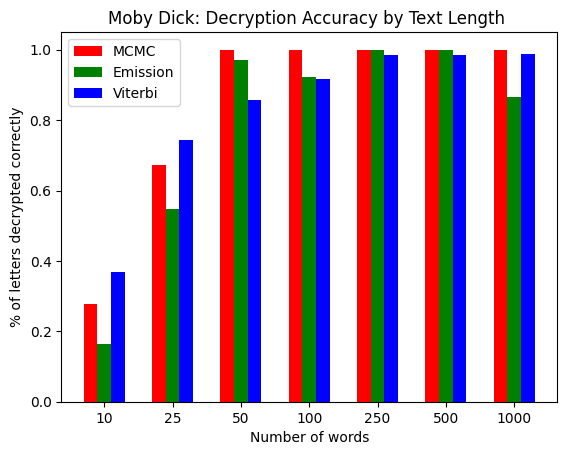

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of labels for the x-axis
labels = [str(length) for length in lengths]
print(labels)

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(labels))

# Plot the results using a bar plot
plt.bar(x_pos - bar_width, Moby_Dick_accuracy_MCMC, bar_width, color="r", label="MCMC")
plt.bar(x_pos, Moby_Dick_accuracy_HMM_emission, bar_width, color="g", label="Emission")
plt.bar(
    x_pos + bar_width,
    Moby_Dick_accuracy_HMM_viterbi,
    bar_width,
    color="b",
    label="Viterbi",
)

# Add labels, title, and legend
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.title("Moby Dick: Decryption Accuracy by Text Length ")
plt.xticks(x_pos, labels)
plt.legend()

# Display the plot
plt.show()

['10', '25', '50', '100', '250', '500', '1000']


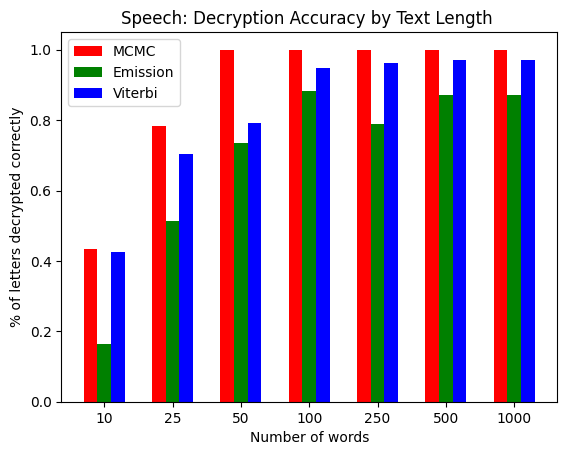

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of labels for the x-axis
labels = [str(length) for length in lengths]
print(labels)

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(labels))

# Plot the results using a bar plot
plt.bar(x_pos - bar_width, speech_accuracy_MCMC, bar_width, color="r", label="MCMC")
plt.bar(x_pos, speech_accuracy_HMM_emission, bar_width, color="g", label="Emission")
plt.bar(
    x_pos + bar_width,
    speech_accuracy_HMM_viterbi,
    bar_width,
    color="b",
    label="Viterbi",
)

# Add labels, title, and legend
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.title("Speech: Decryption Accuracy by Text Length ")
plt.xticks(x_pos, labels)
plt.legend()

# Display the plot
plt.show()

['10', '25', '50', '100', '250', '500', '1000']


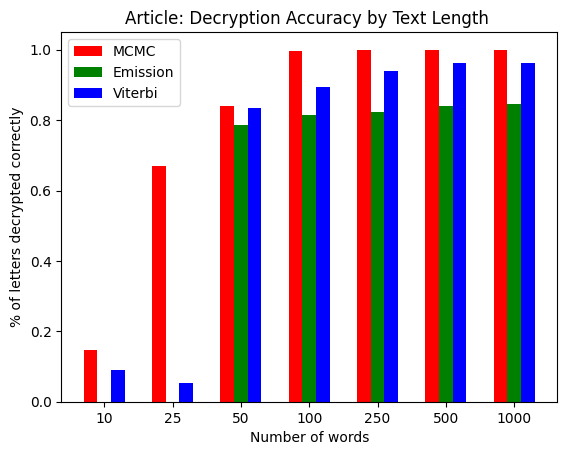

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list of labels for the x-axis
labels = [str(length) for length in lengths]
print(labels)

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(labels))

# Plot the results using a bar plot
plt.bar(
    x_pos - bar_width, article_tipping_accuracy_MCMC, bar_width, color="r", label="MCMC"
)
plt.bar(
    x_pos, article_tipping_accuracy_HMM_emission, bar_width, color="g", label="Emission"
)
plt.bar(
    x_pos + bar_width,
    article_tipping_accuracy_HMM_viterbi,
    bar_width,
    color="b",
    label="Viterbi",
)

# Add labels, title, and legend
plt.xlabel("Number of words")
plt.ylabel("% of letters decrypted correctly")
plt.title("Article: Decryption Accuracy by Text Length ")
plt.xticks(x_pos, labels)
plt.legend()

# Display the plot
plt.show()